# Boxplots

## Script setup

In [20]:
# Third-party and standard modules
from typing import Dict, Hashable
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import pytz
from importlib import reload

# User-defined modules.
# The reload() function is needed to update modules after
# changes are made to their files.
from modules import dataframe_manip as dfm
from modules import misc, schemas, College1AcPtTimeSeries
# The reload() function is needed to update modules after
# changes are made to their files.
dfm = reload(dfm)
misc = reload(misc)
schemas = reload(schemas)
College1AcPtTimeSeries = reload(College1AcPtTimeSeries)

## Script parameters

The following values are this script's parameters.

In [21]:
filepath = './cisco_wifi_data_until_20190513.csv'
timezone = pytz.timezone('US/Pacific')
schema: schemas.AcPtTimeSeries =\
    College1AcPtTimeSeries.College1AcPtTimeSeries
buildings = [
    'SCC', 'HAHN', 'CROOKSHANK', 'THATHCHER', 'CLARK',
    'CARNEGIE', 'MASON', 'PEARSON', 'ALEXANDER', 'ITB'
]

## Data Processing

In [22]:
# A time-series dataframe holding occupancy counts
# for many access points (columns).
occ: pd.DataFrame = dfm.csv_to_timeseries_df(
    filepath=filepath, timezone=timezone
)

In [23]:
# Eliminate columns for access points not in the buildings we want.
occ = occ.drop(columns=list(filter(
    # add to drop-list if NOT in the buildings we want.
    lambda col: schema.col_to_building(col, safe=True) not in buildings,
    occ.columns.to_list()
)))

# We must assume that intervening na-values are 0's.
occ = dfm.fill_intervening_nas(
    occ, inplace=True, fill_val=0
)

/Users/josalvatorre/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [24]:
occ_bybuild = occ.groupby(
    by=schema.col_to_building, axis=1
)

In [25]:
print('buildings not found: {}'.format(set(buildings) - set(occ_bybuild.groups.keys())))

# We can only work with the buildings we found.
buildings = list(occ_bybuild.groups.keys())

buildings not found: {'PEARSON', 'CROOKSHANK', 'THATHCHER'}


In [26]:
means_by_building: Dict[Hashable, pd.DataFrame] = {}
maxmean = float('-inf')
for build in buildings:
    means_by_building[build] = dfm.row_means(occ_bybuild.get_group(build))
    newmax = means_by_building[build].max()
    newmin = means_by_building[build].min()
    maxmean = newmax if newmax > maxmean else maxmean
print(maxmean)

19.142857142857142


## Boxplots

/Users/josalvatorre/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


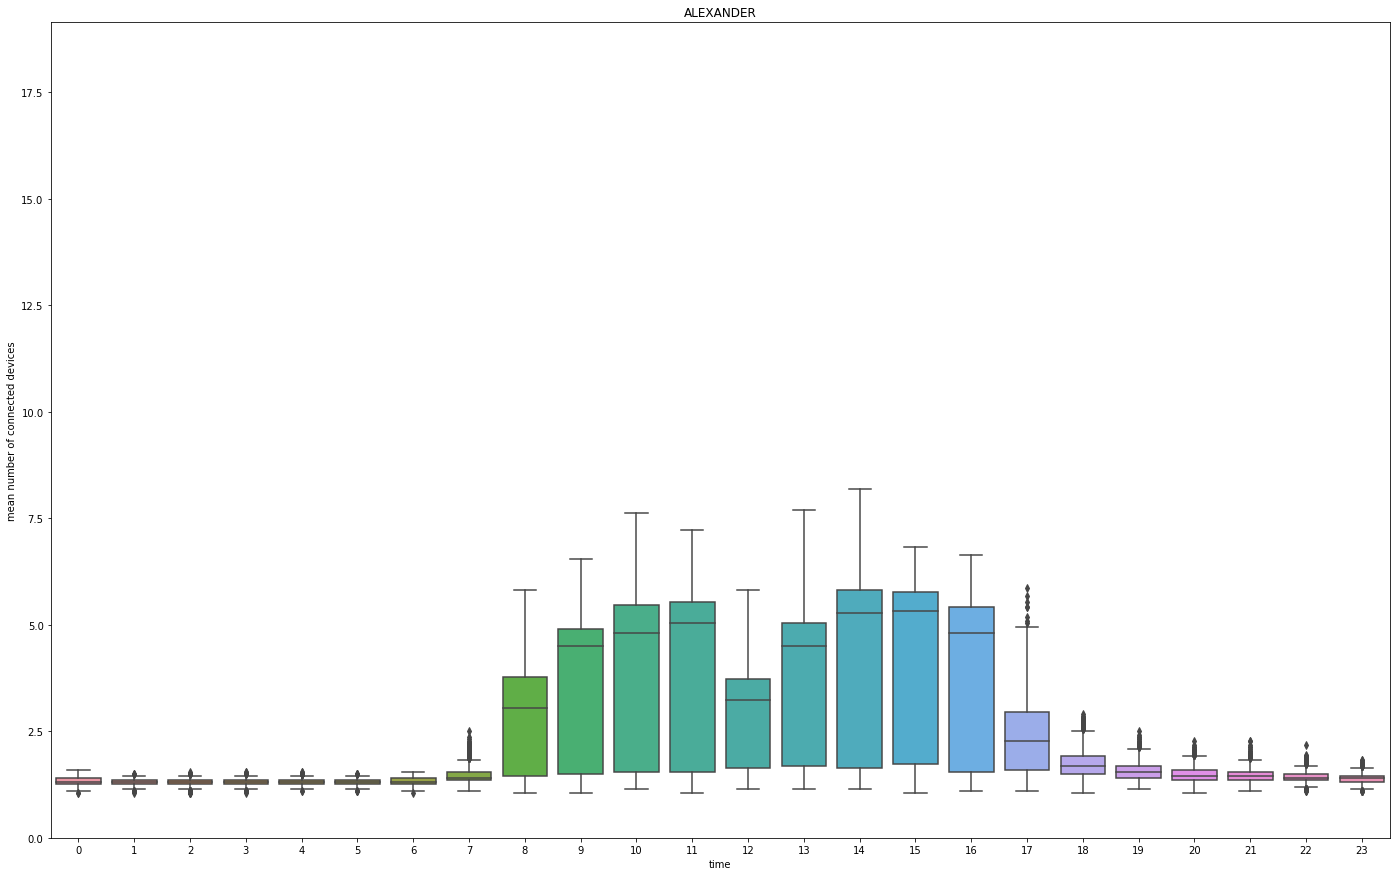

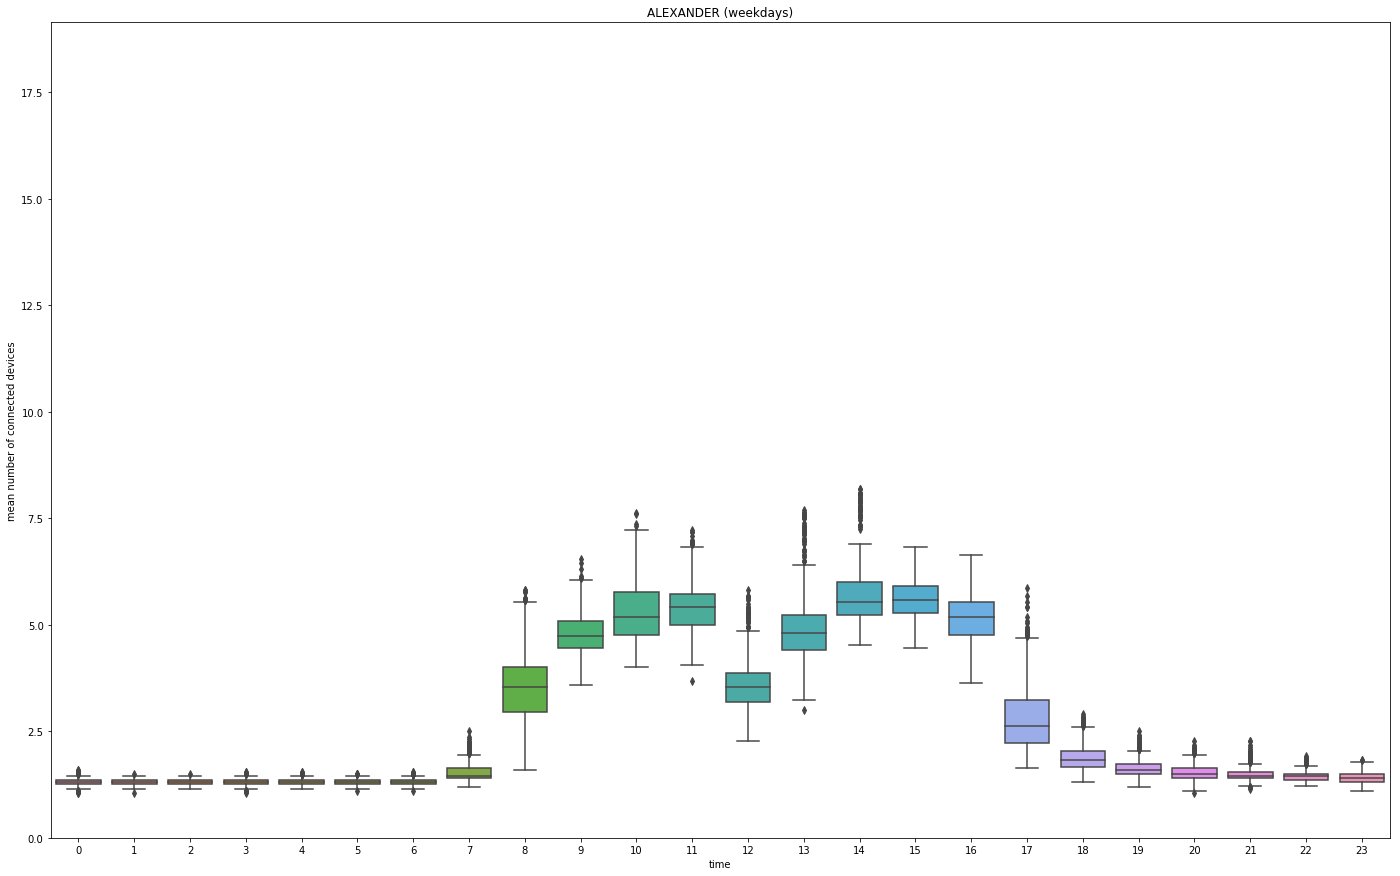

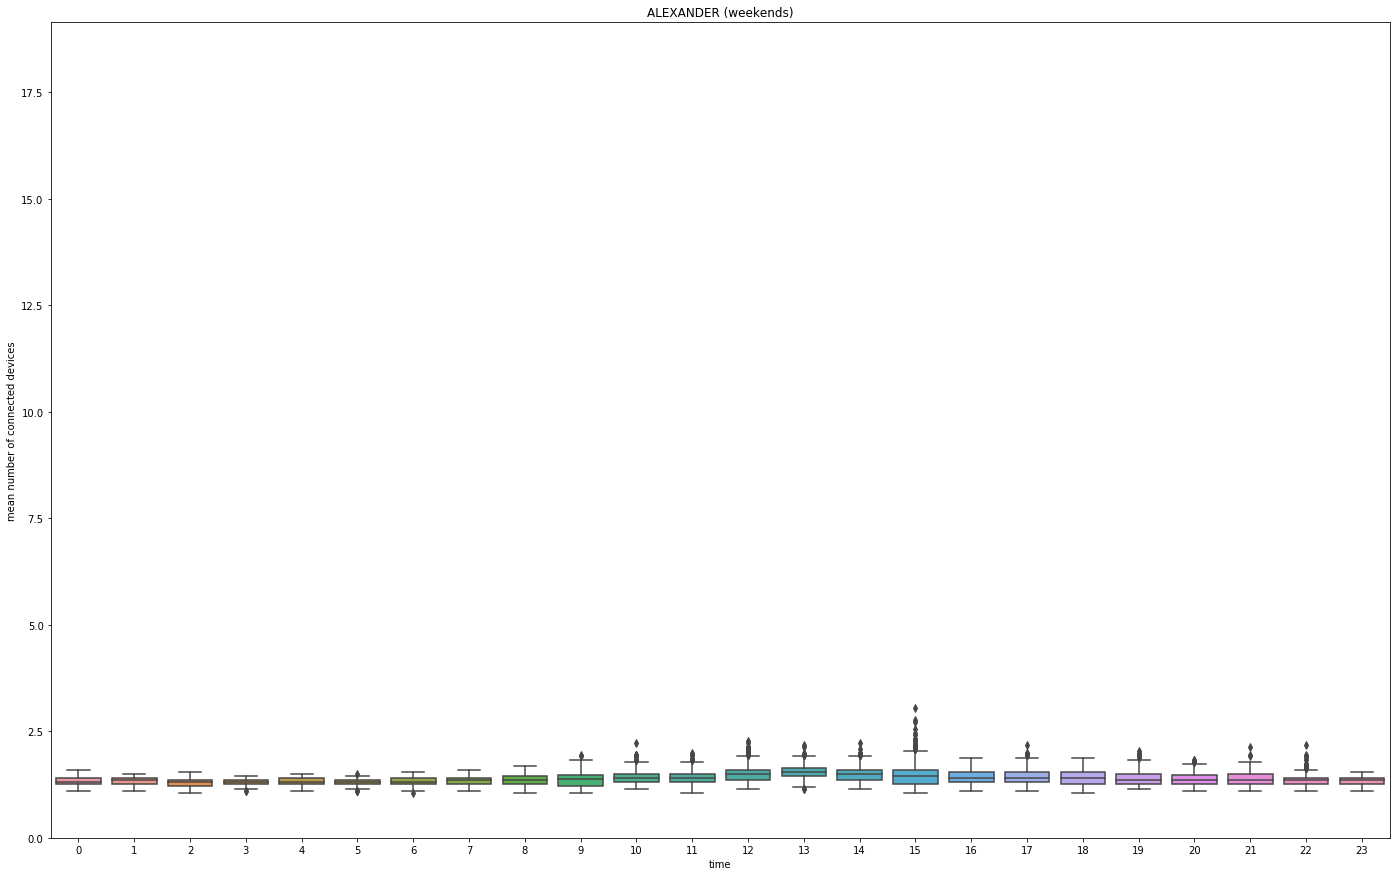

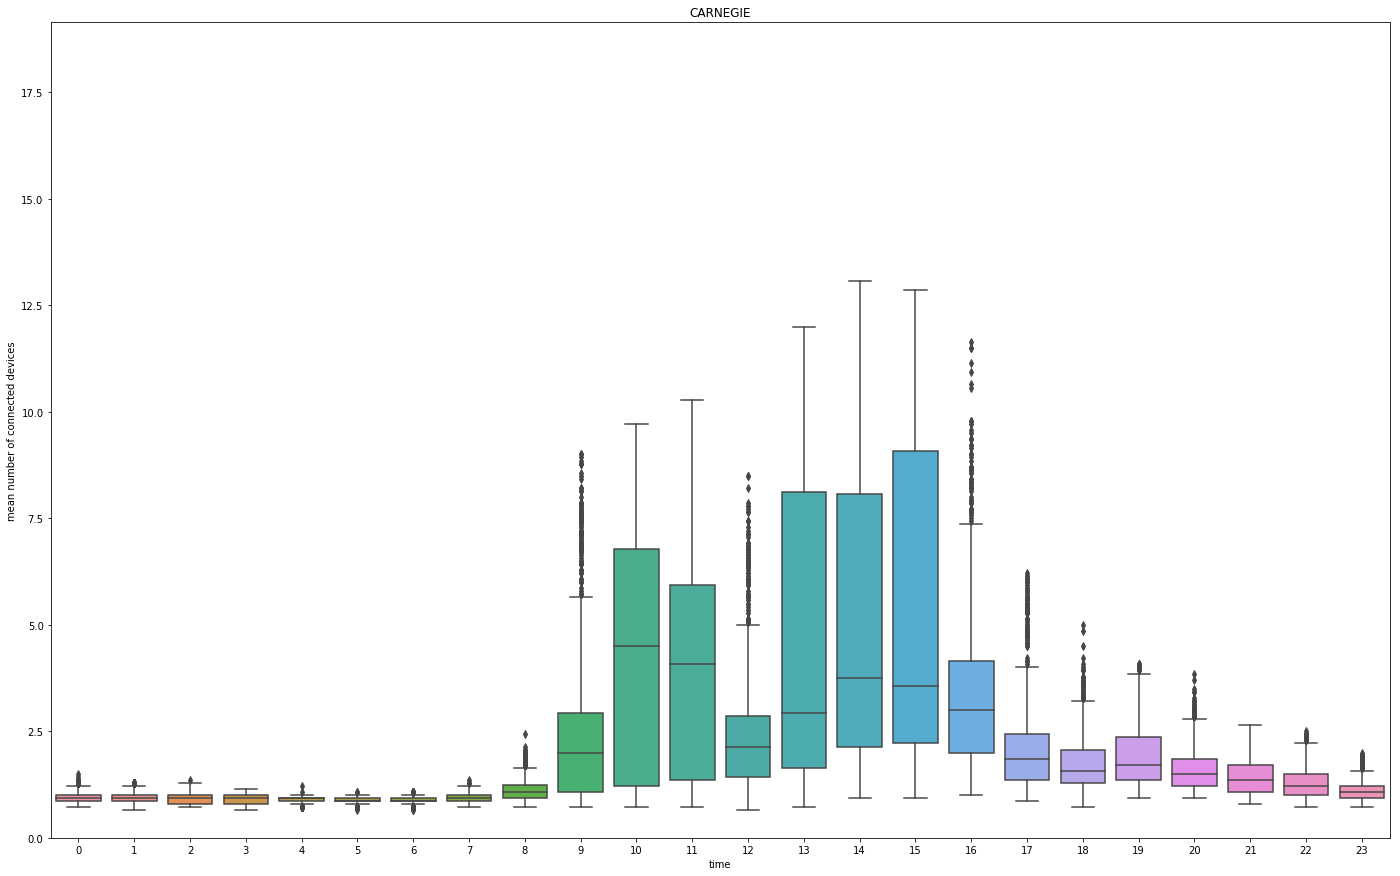

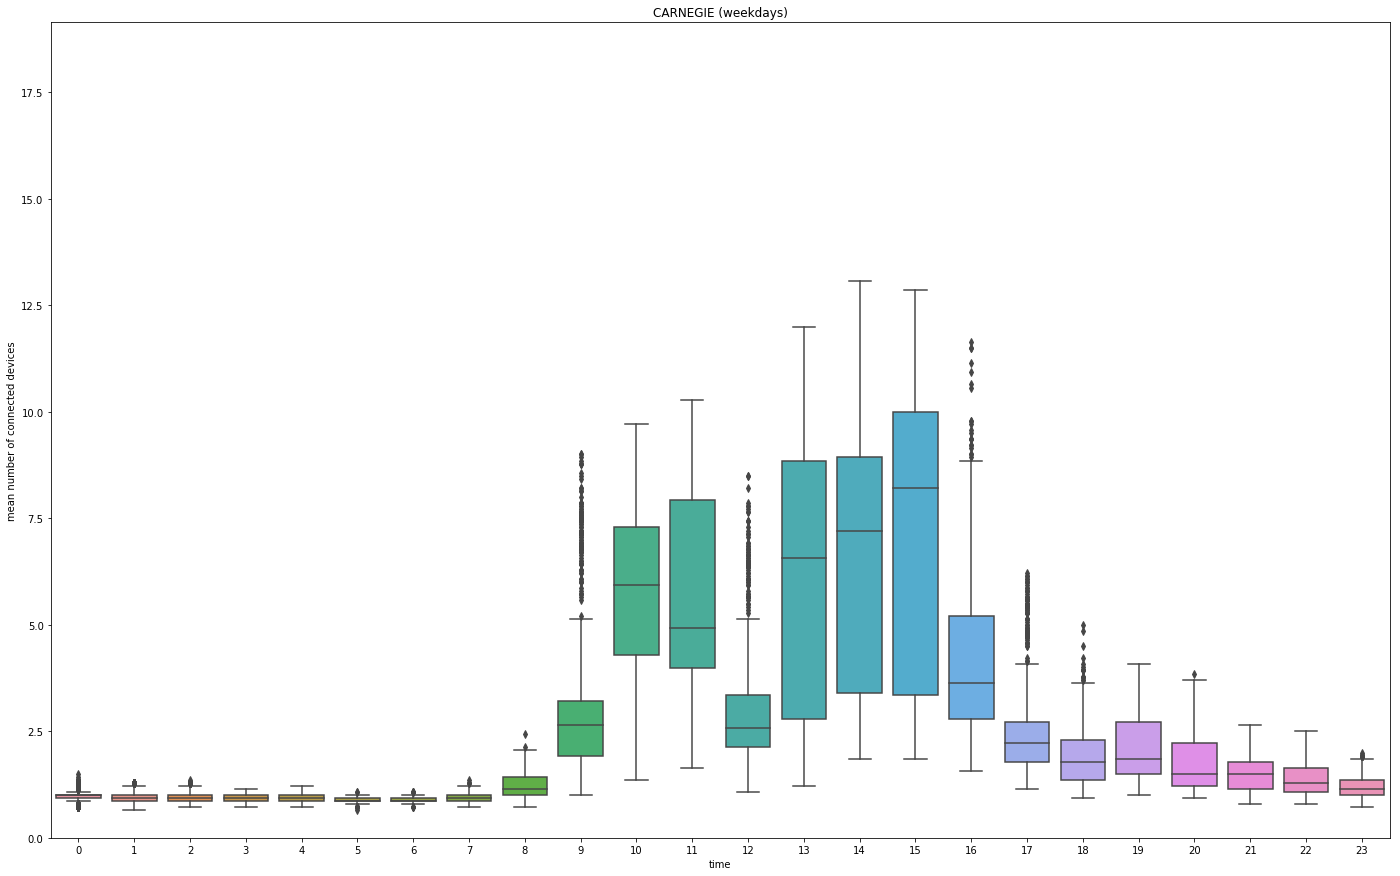

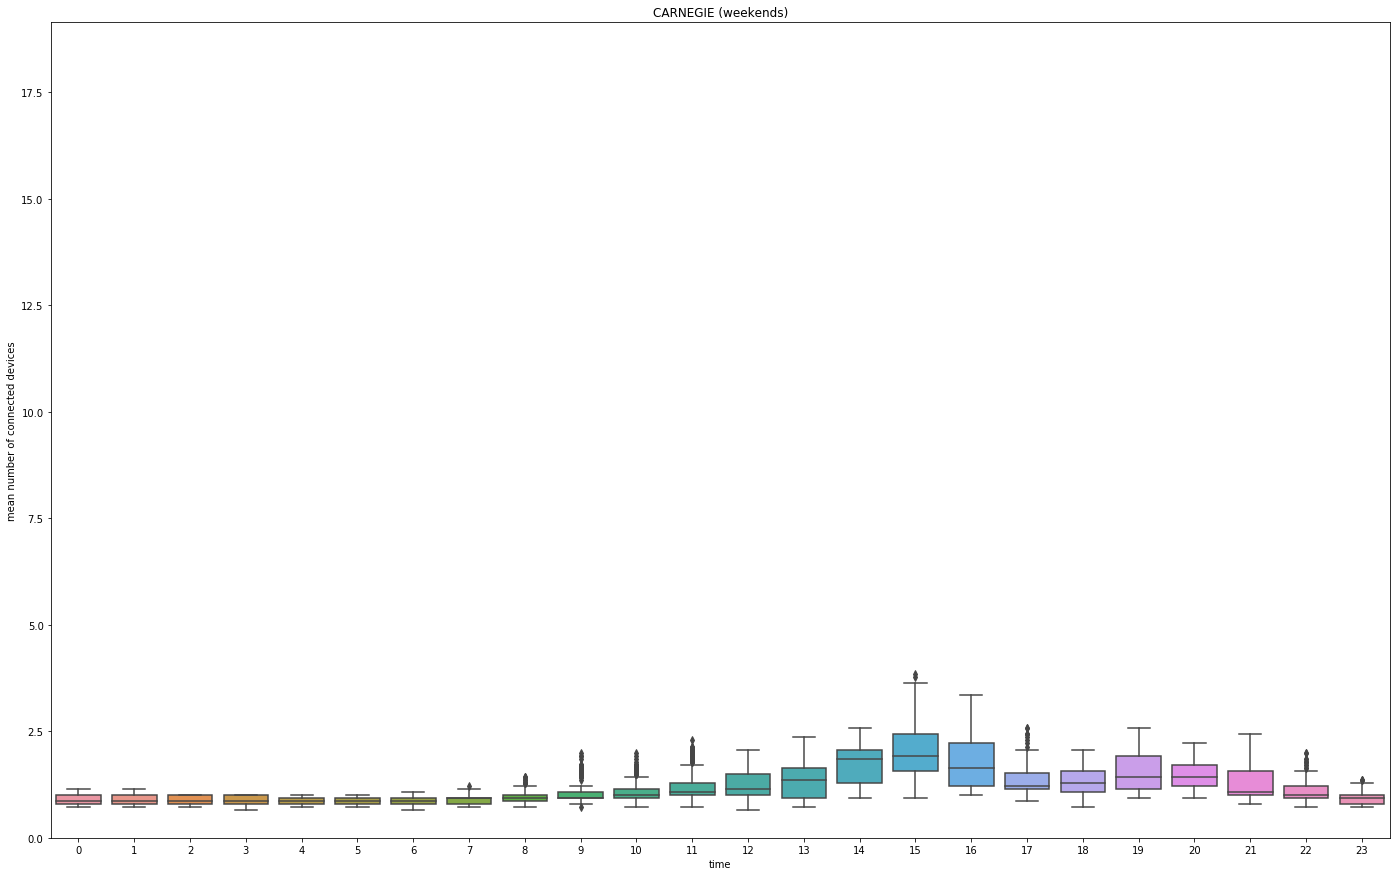

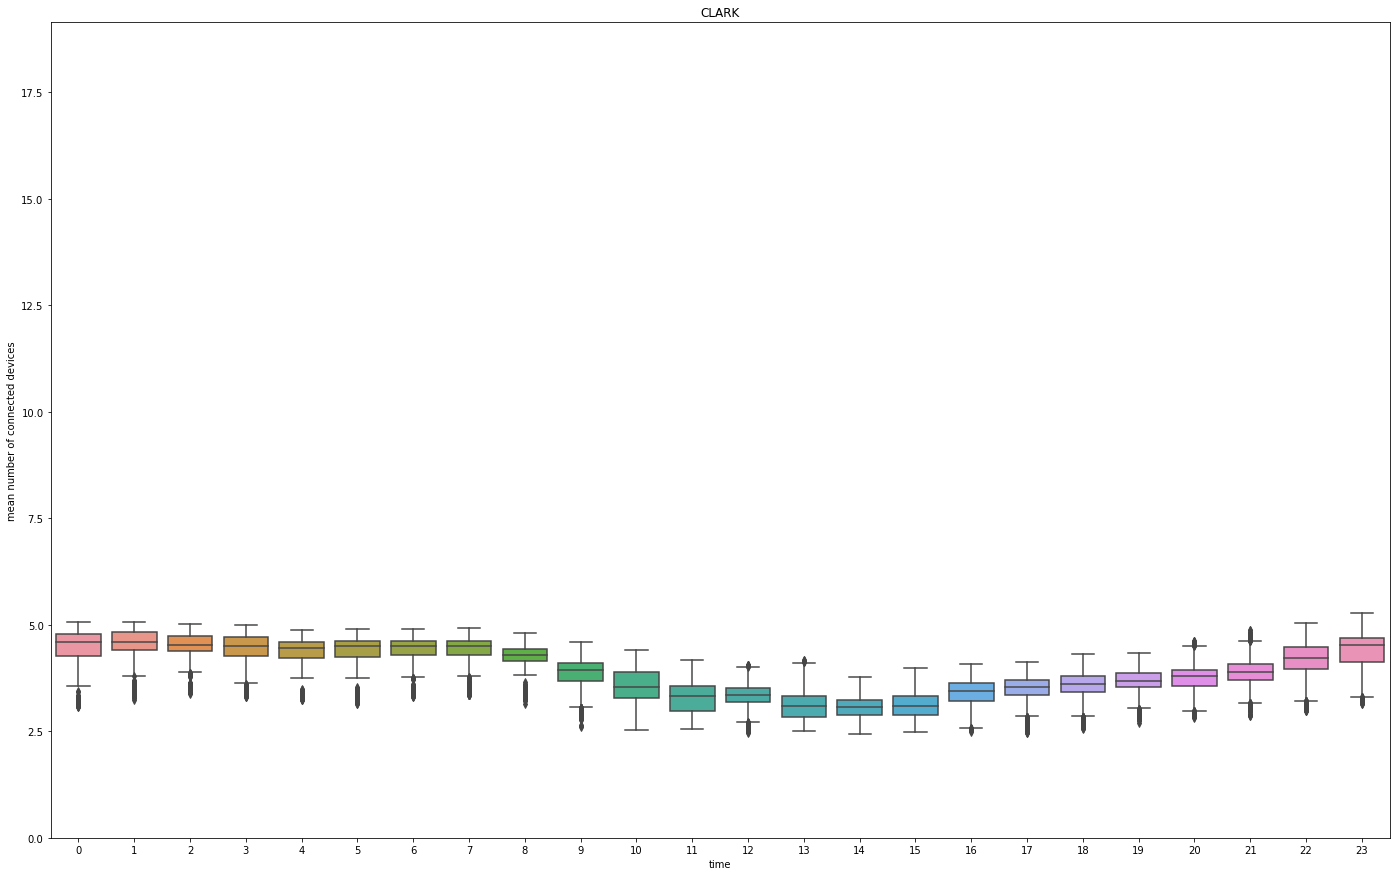

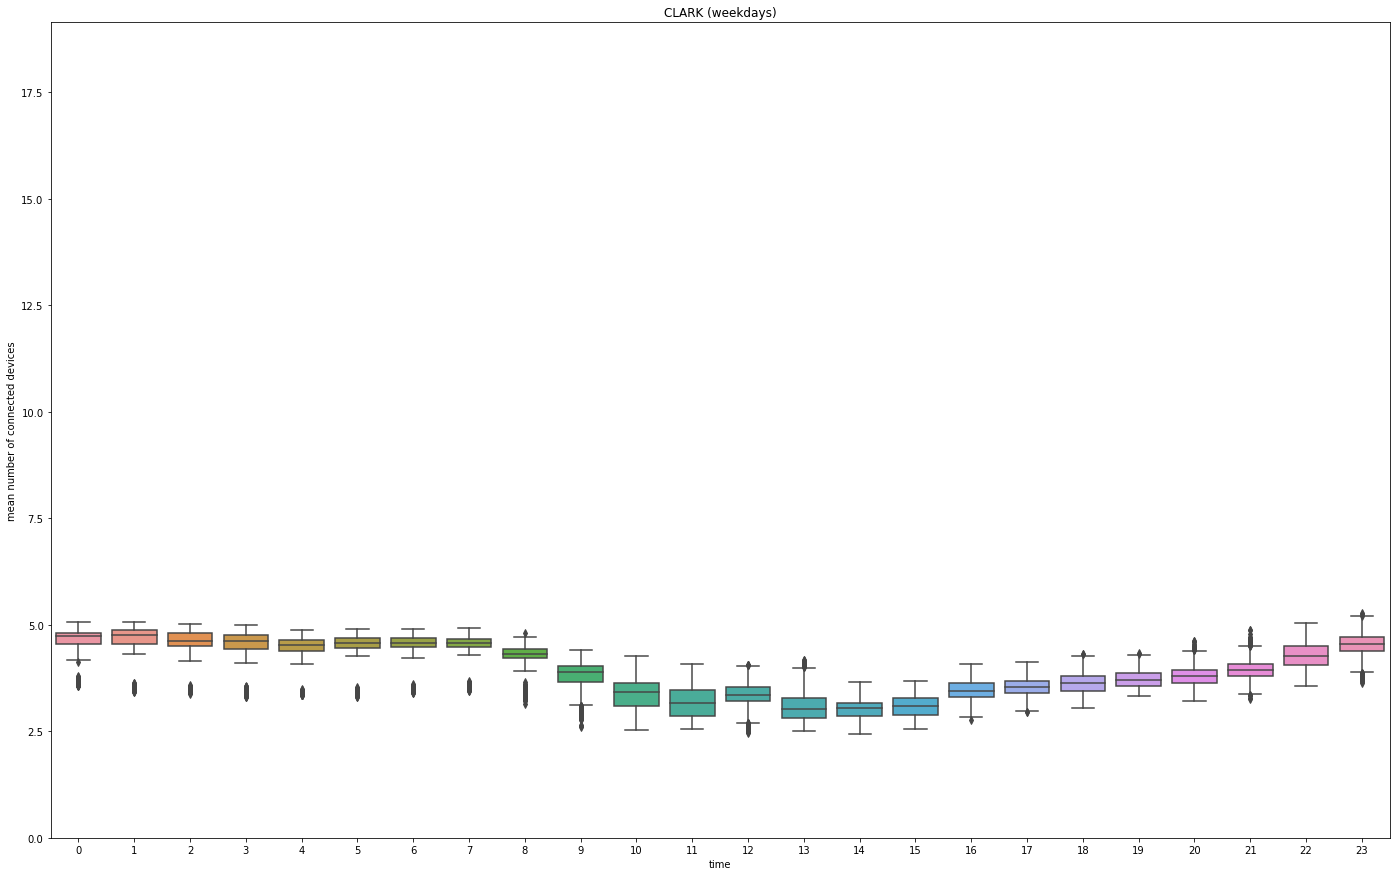

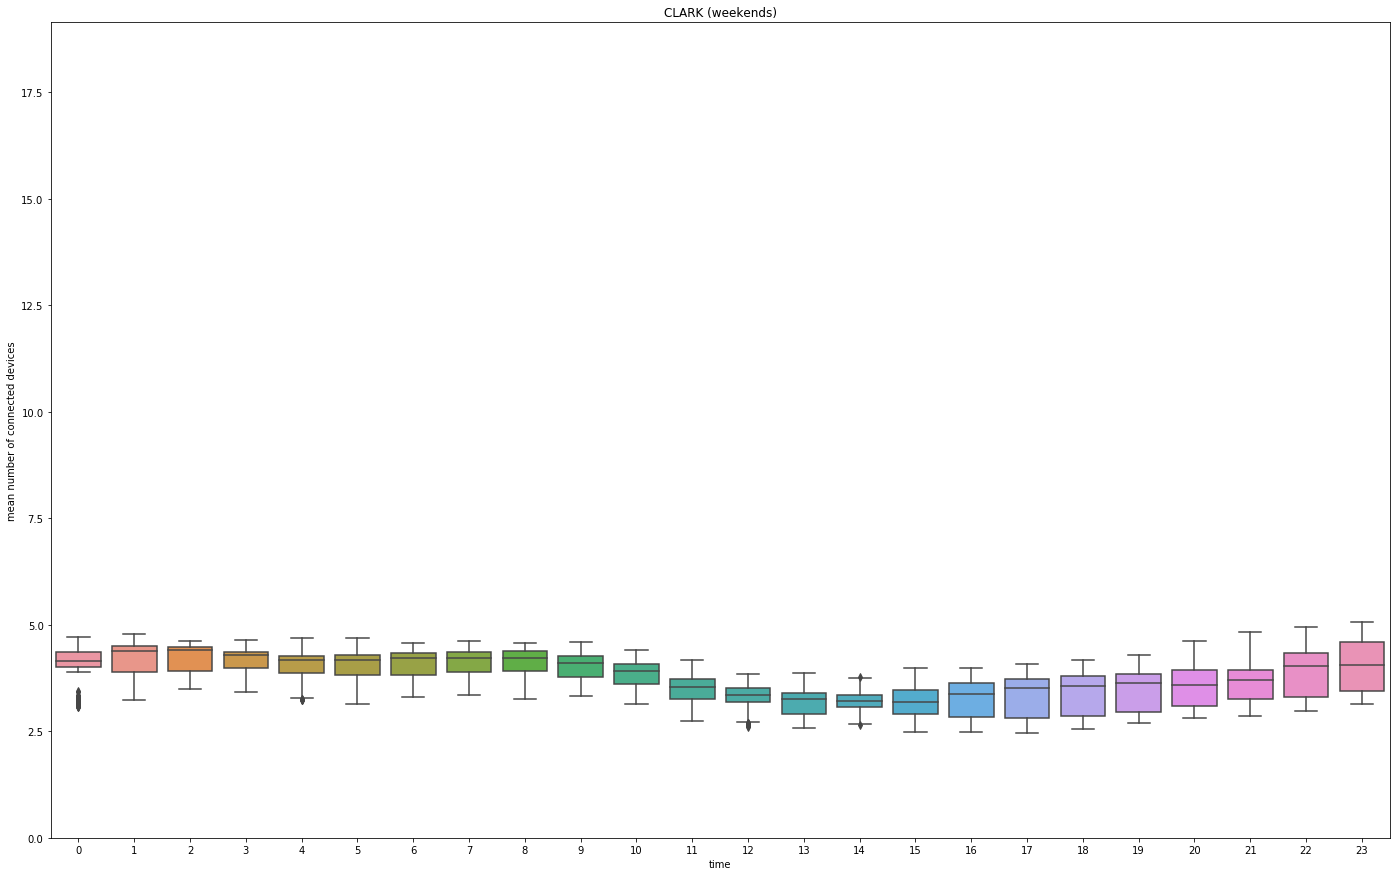

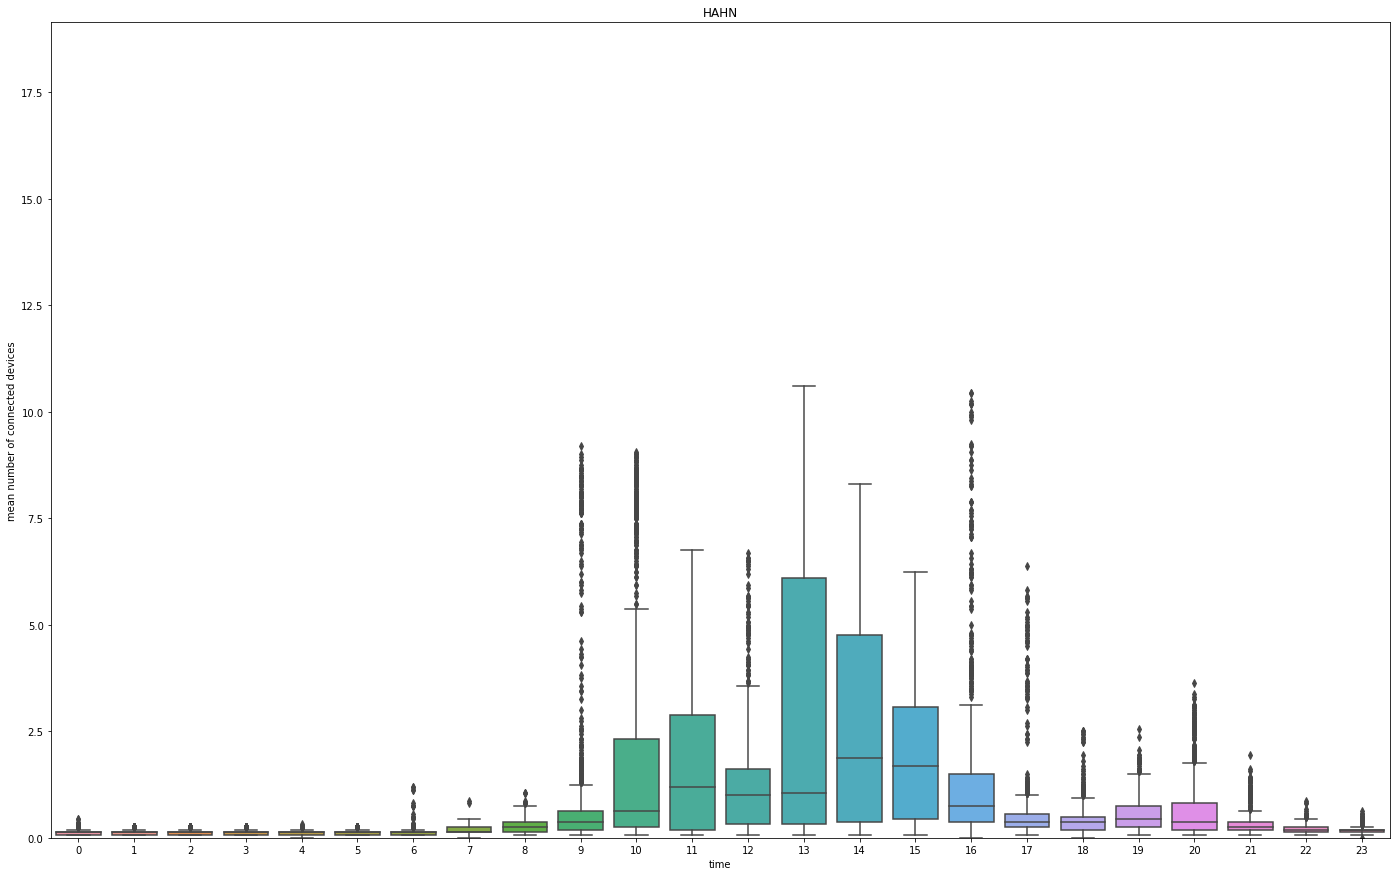

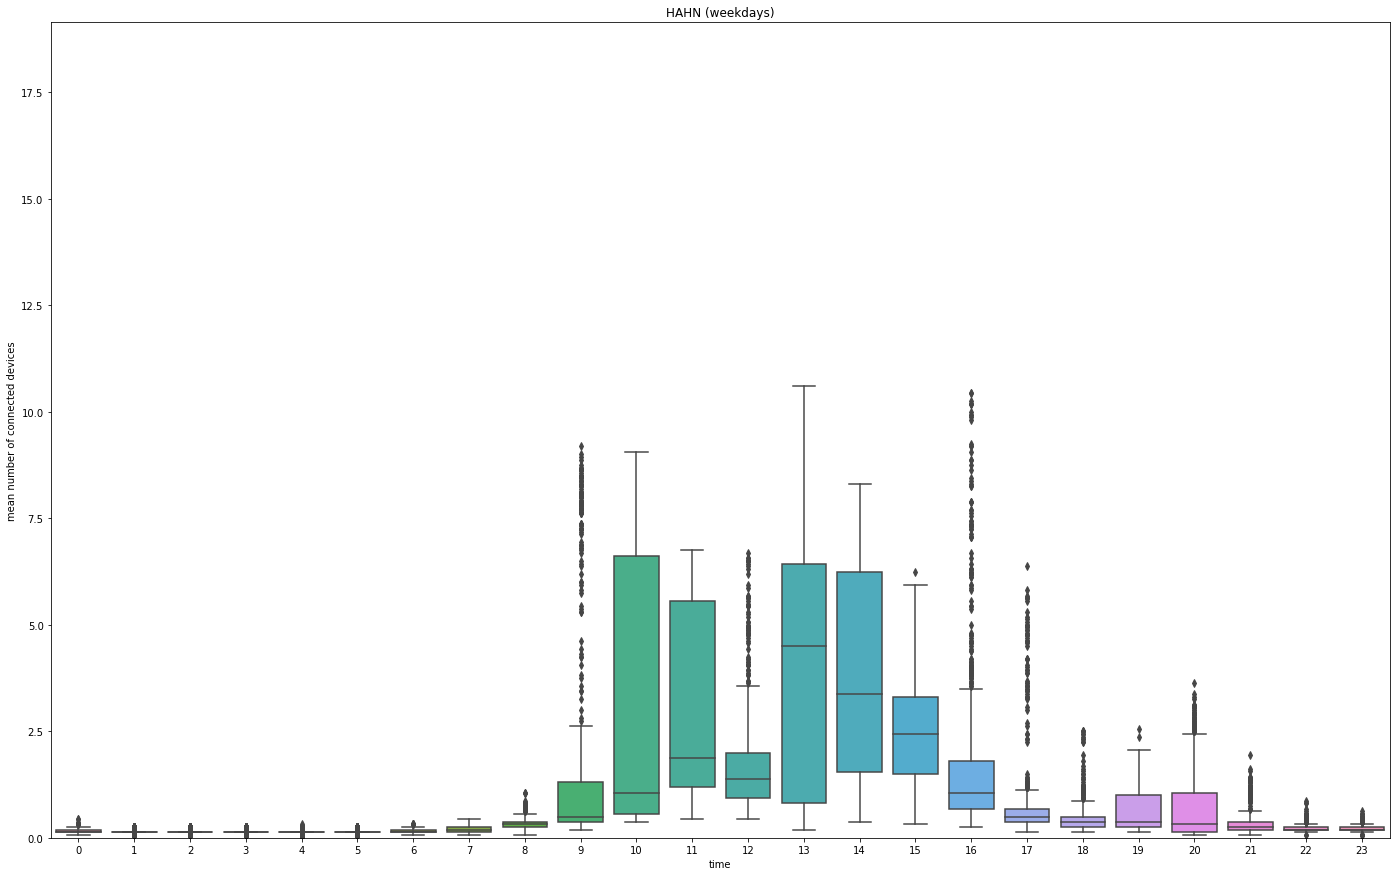

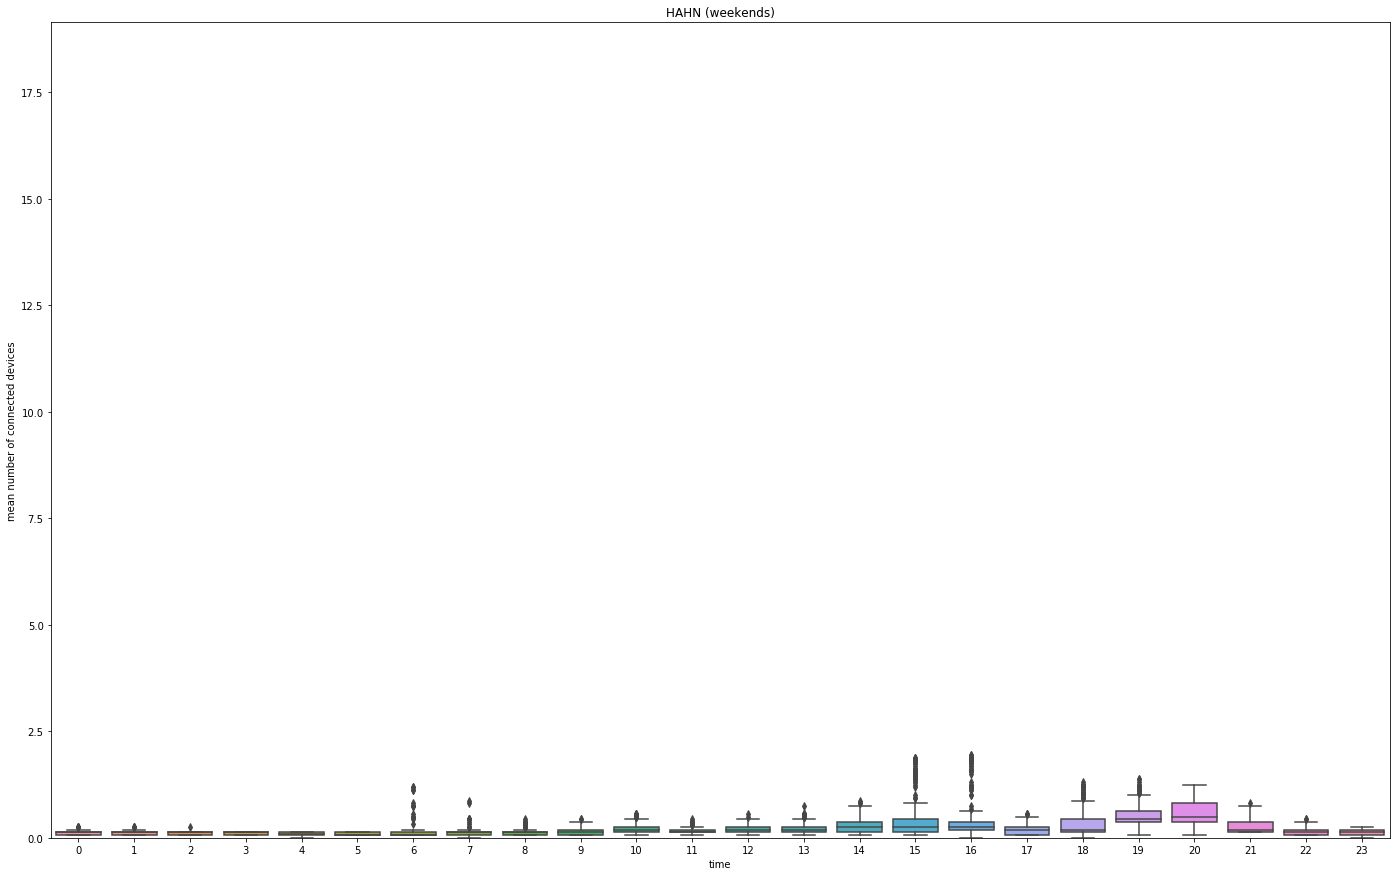

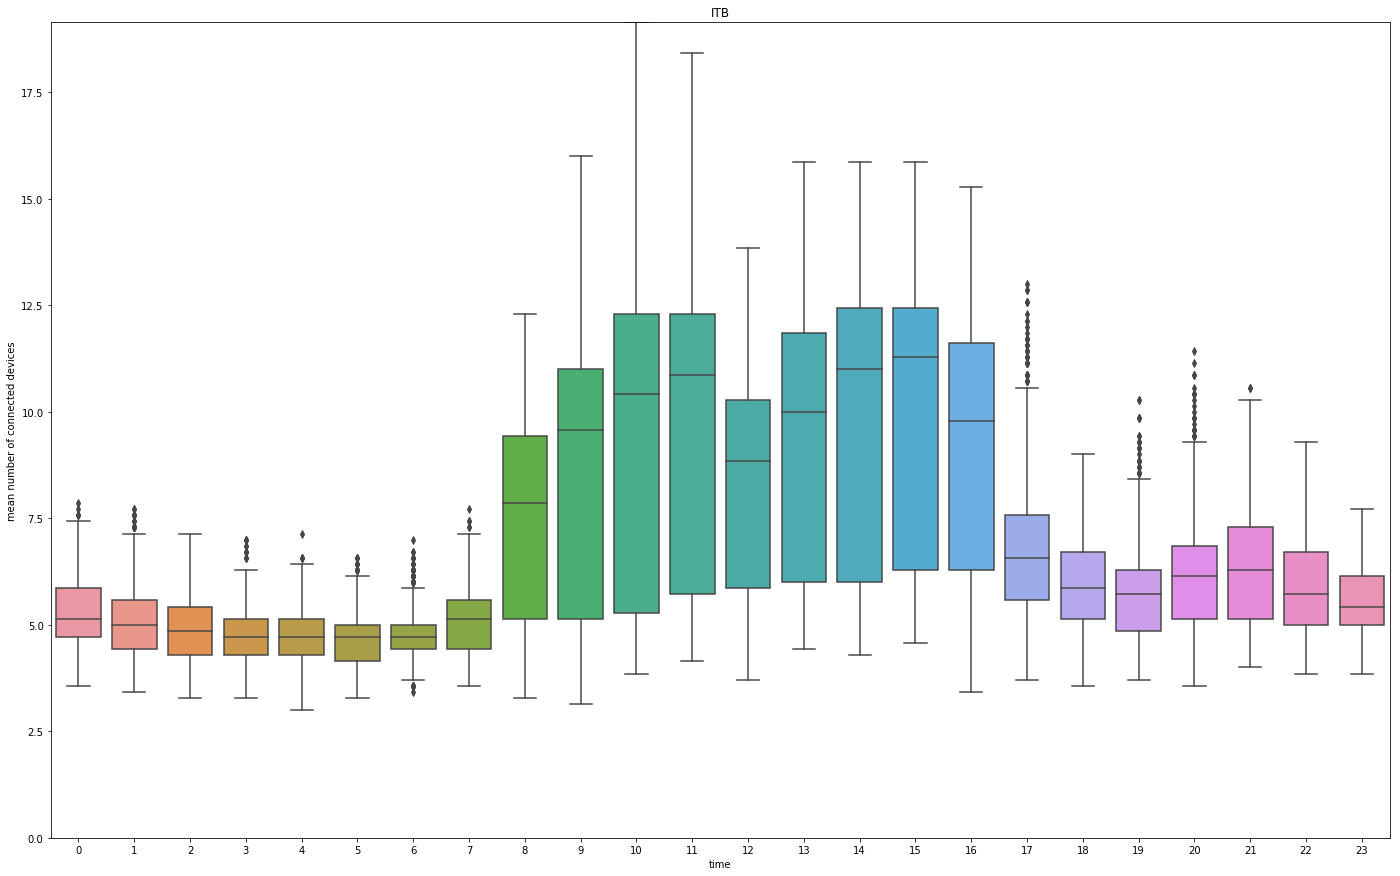

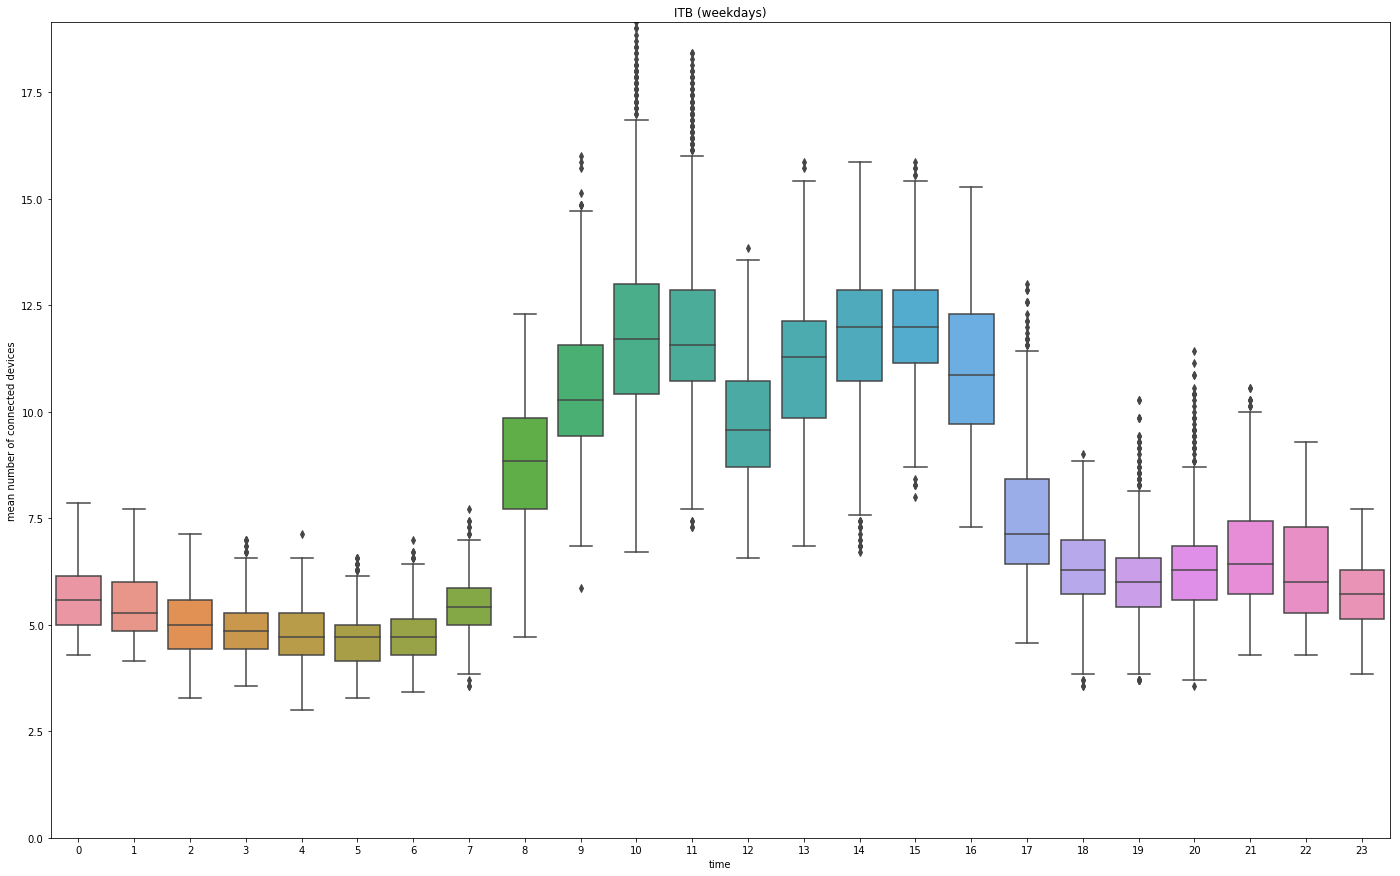

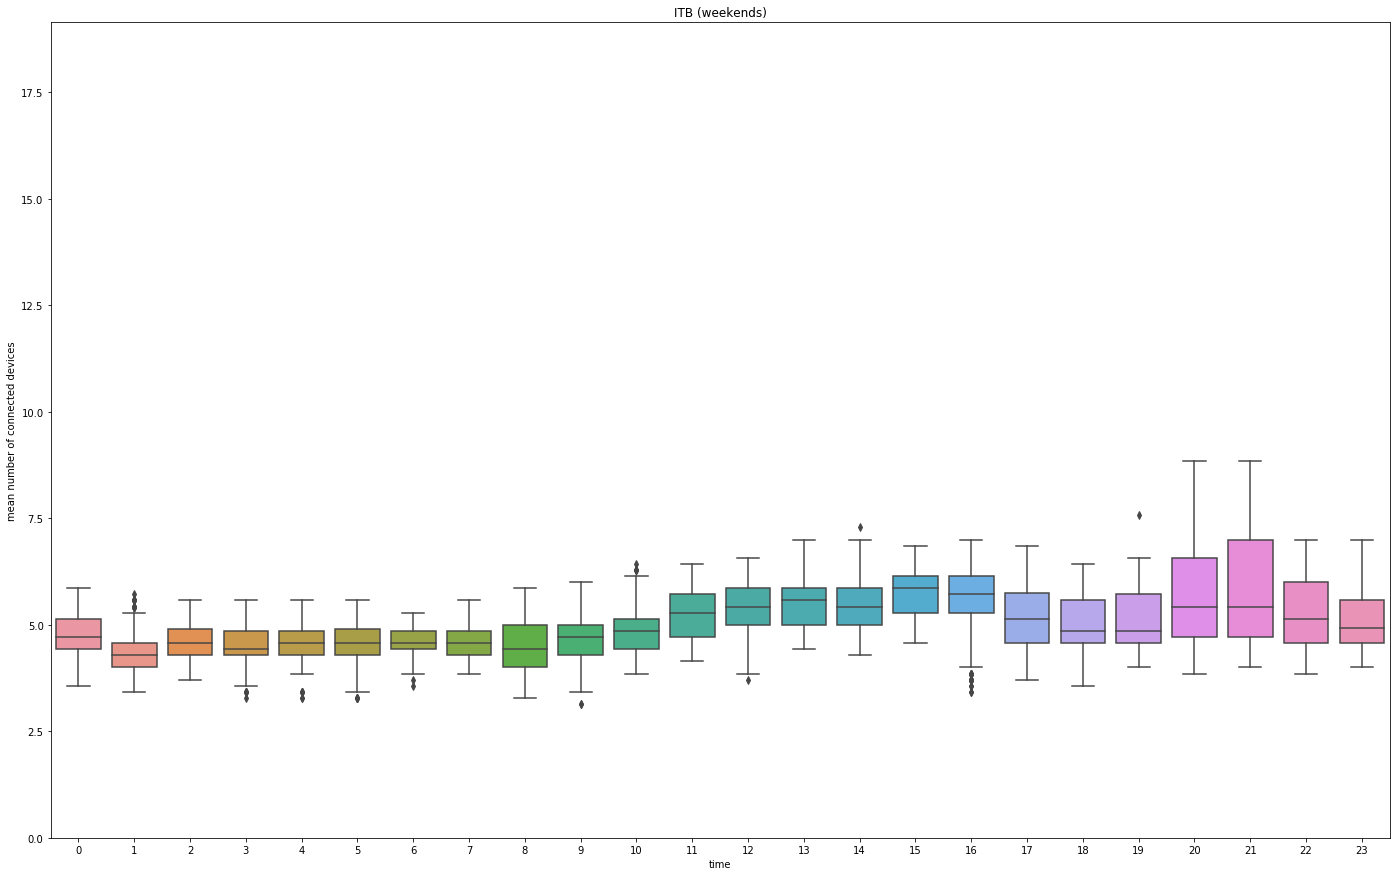

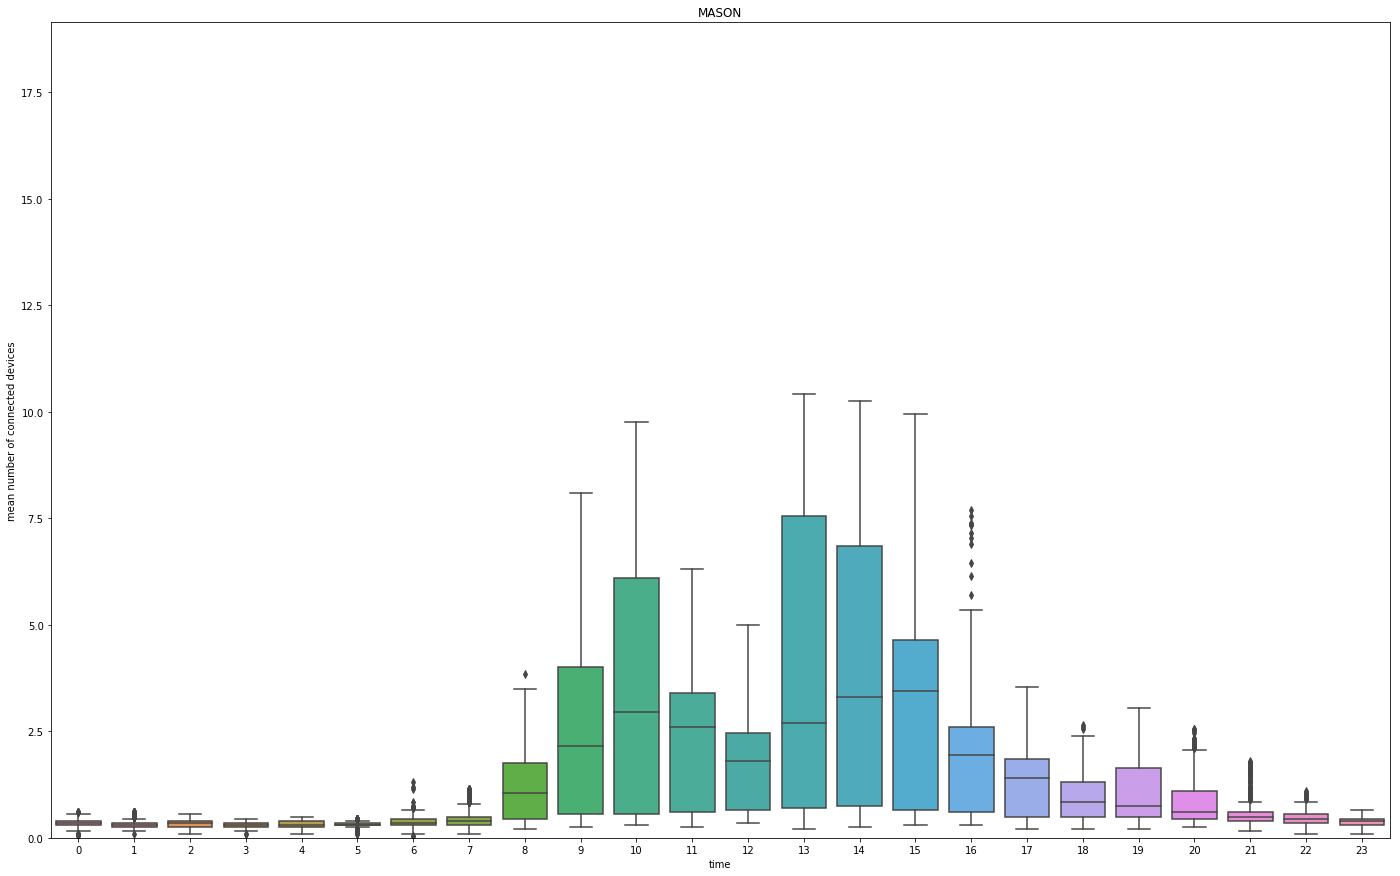

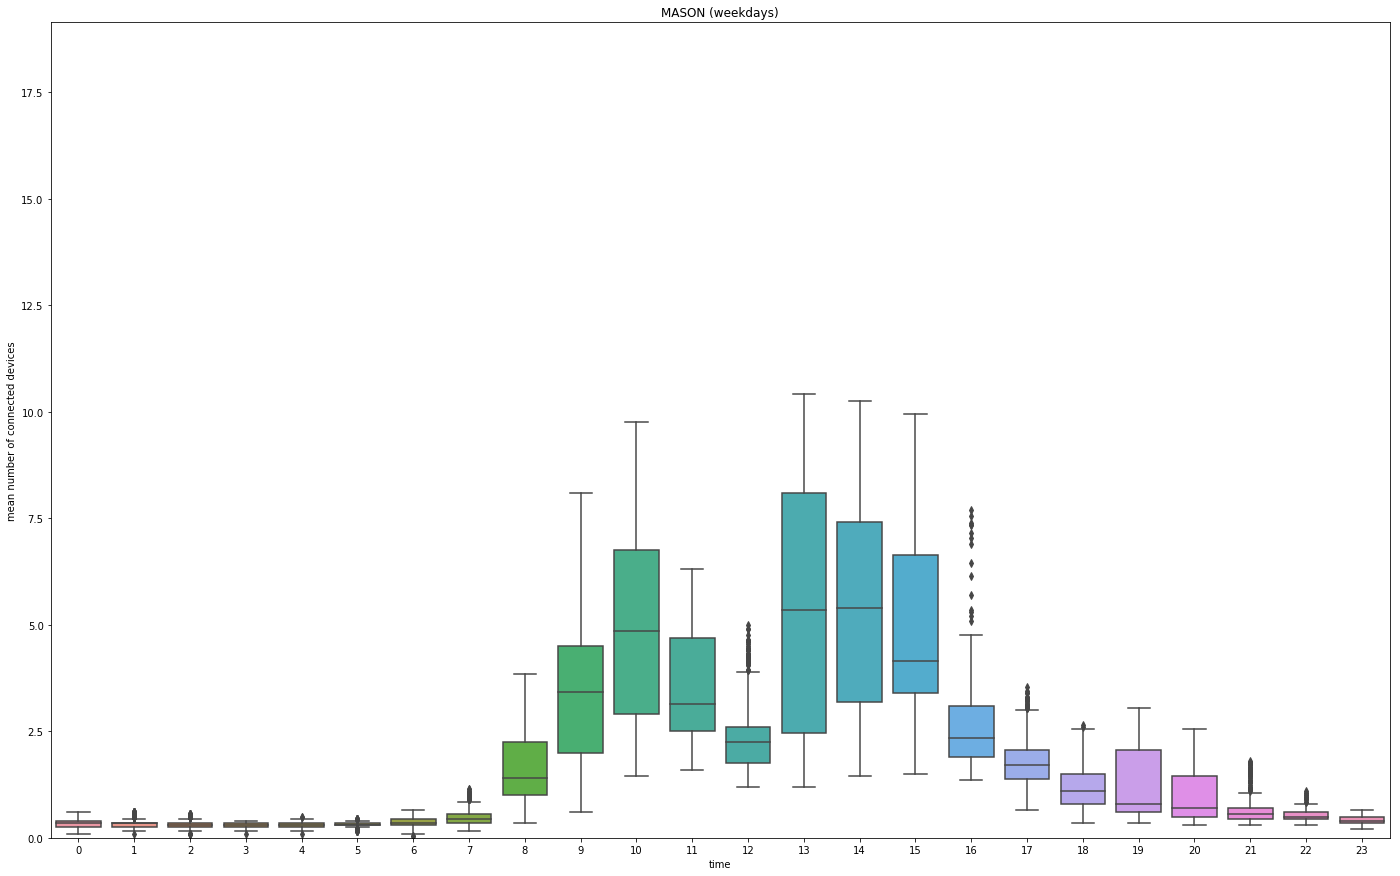

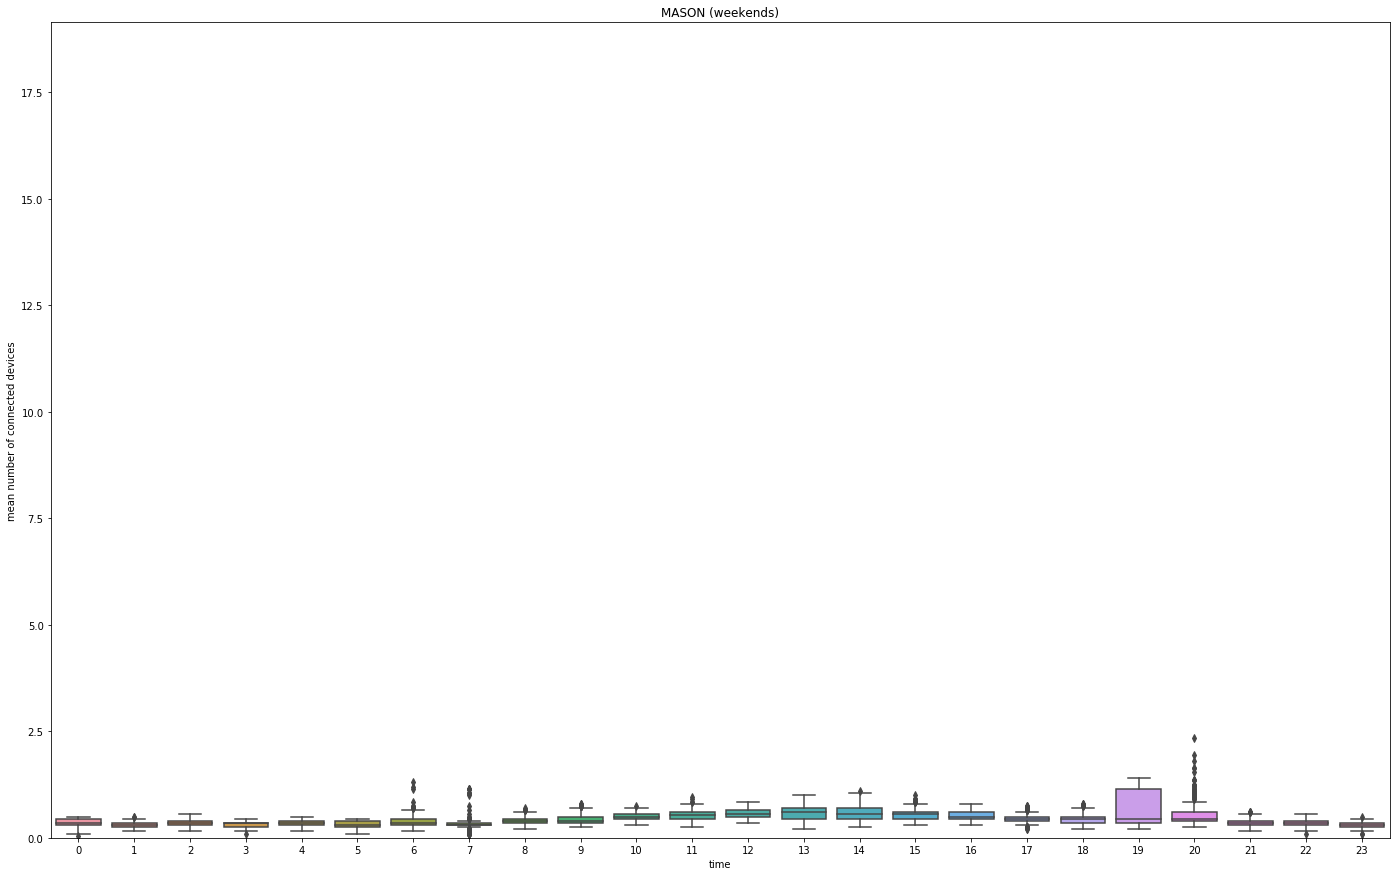

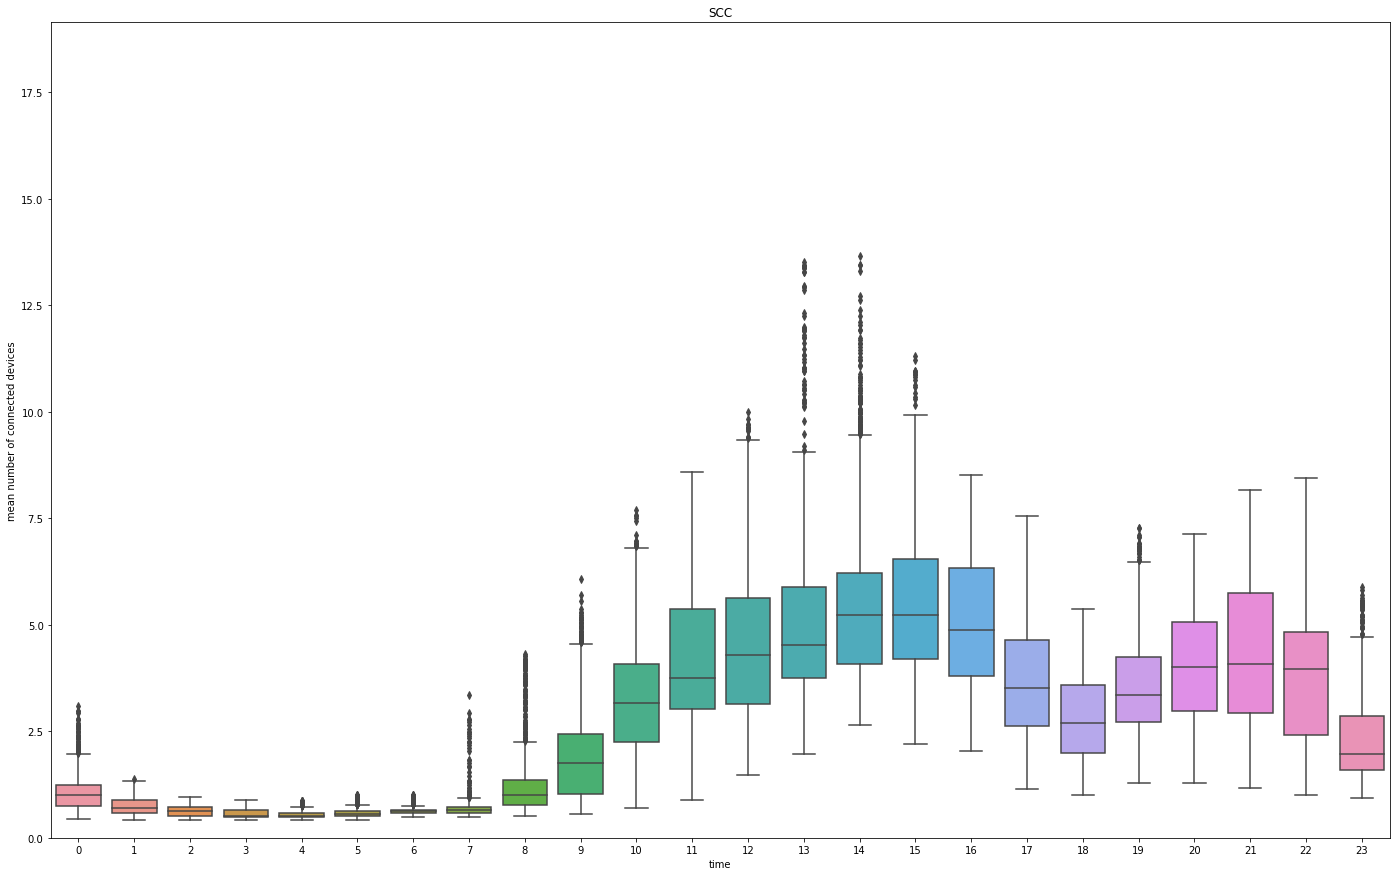

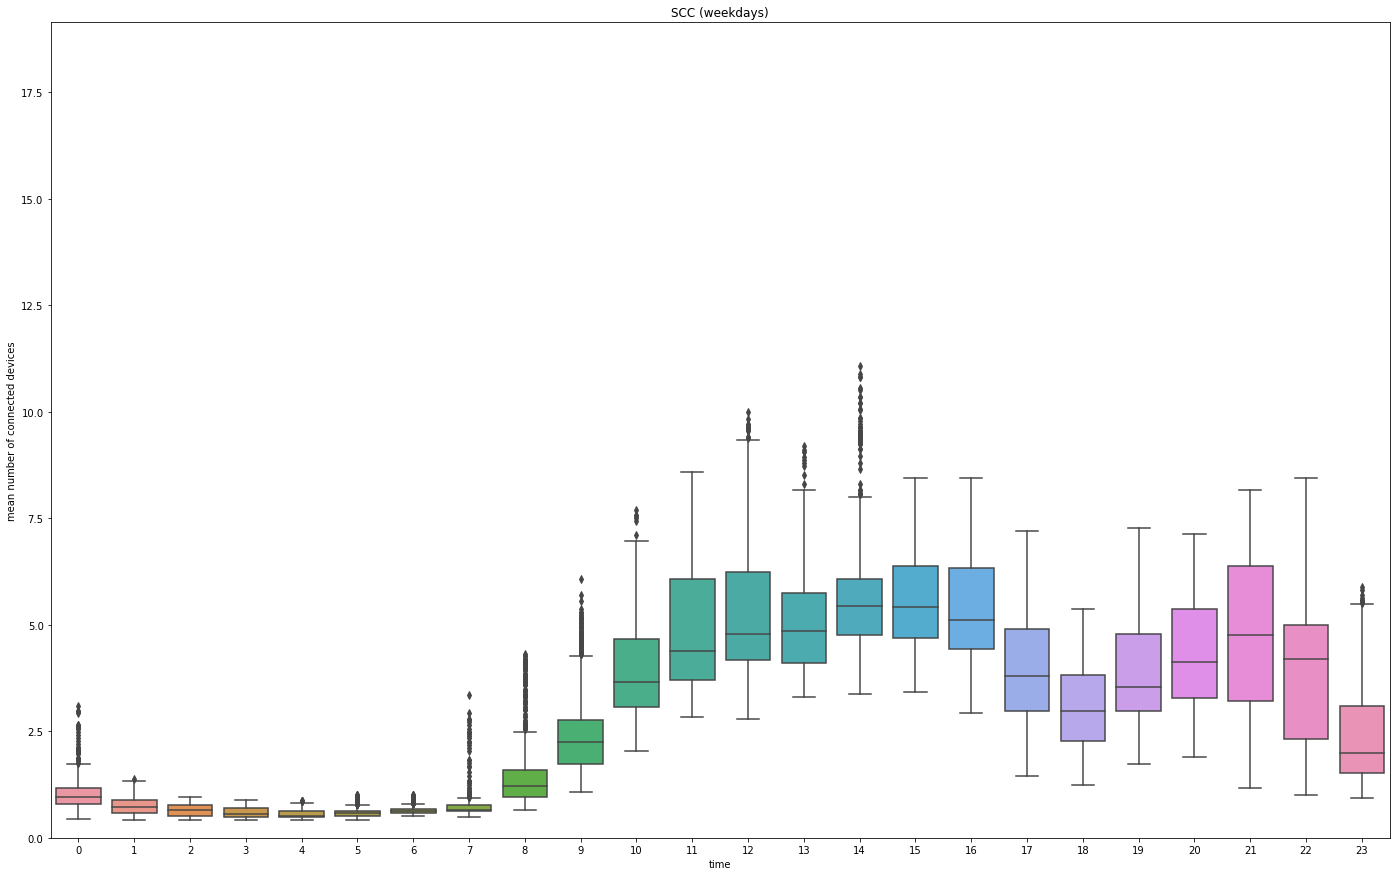

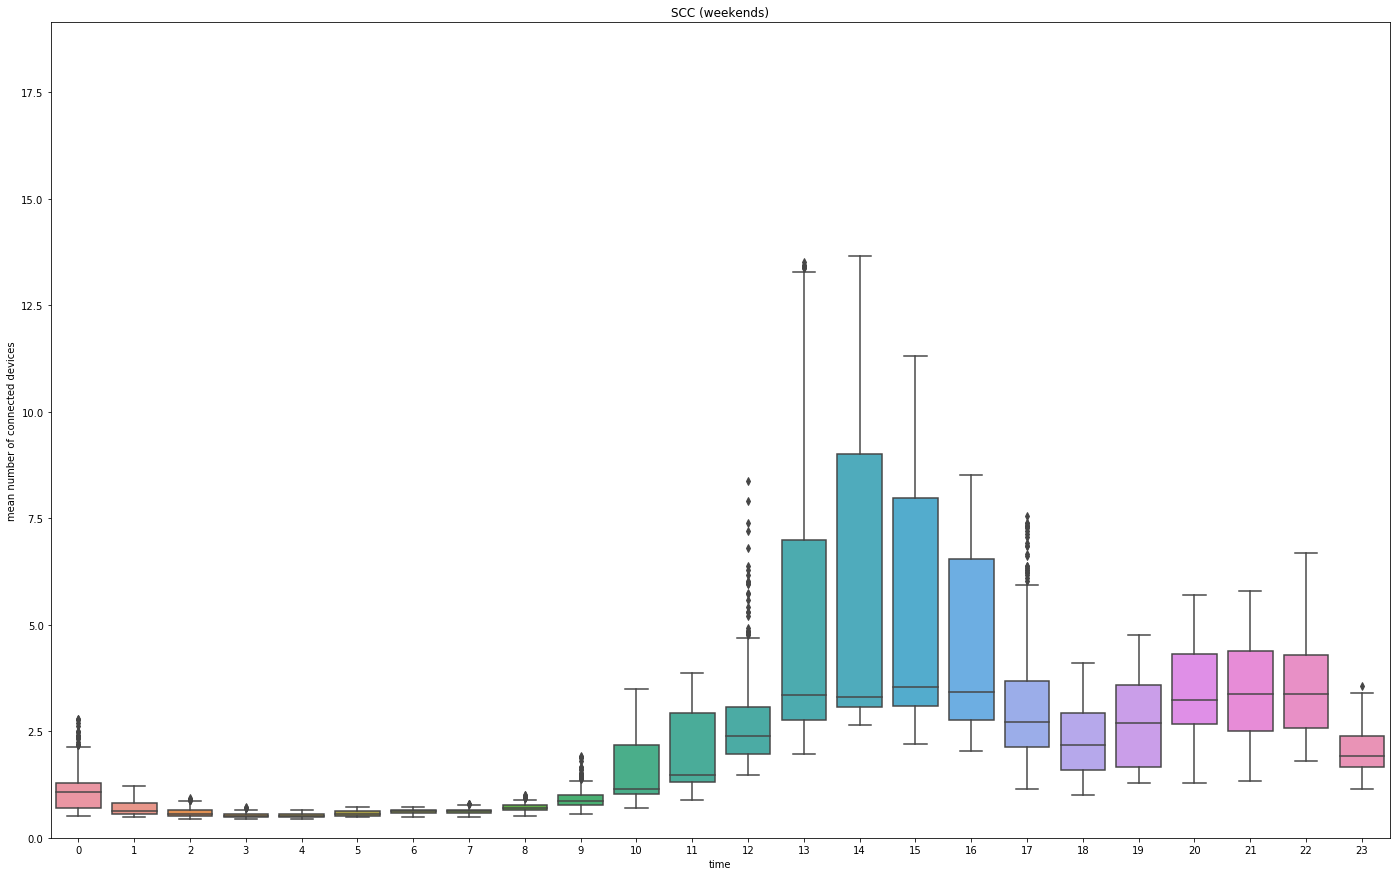

In [27]:
for build in buildings:
    mean_occ: pd.DataFrame = dfm.row_means(occ_bybuild.get_group(build))
    
    fig, ax = plt.subplots(figsize=(24, 15))
    ax.set_title(build)
    ax.set_xlabel('hour of the day')
    ax.set_ylabel('mean number of connected devices')
    ax.set_ylim(0, maxmean)
    
    seaborn.boxplot(
        # The hours (a number [0,23]) for each row.
        x=mean_occ.index.hour,
        # The total occupancy at that hour.
        y=mean_occ,
        ax=ax
    )
    

    fig, ax = plt.subplots(figsize=(24, 15))
    ax.set_title(build + ' (weekdays)')
    ax.set_xlabel('hour of the day')
    ax.set_ylabel('mean number of connected devices')
    ax.set_ylim(0, maxmean)
    
    wkdays = mean_occ.loc[mean_occ.index.dayofweek<5].copy()
    
    seaborn.boxplot(
        # The hours (a number [0,23]) for each row.
        x=wkdays.index.hour,
        # The total occupancy at that hour.
        y=wkdays,
        ax=ax
    )
    fig.savefig('./{}.png'.format(build))
    
    fig, ax = plt.subplots(figsize=(24, 15))
    ax.set_title(build + ' (weekends)')
    ax.set_xlabel('hour of the day')
    ax.set_ylabel('mean number of connected devices')
    ax.set_ylim(0, maxmean)
    
    wkends = mean_occ.loc[mean_occ.index.dayofweek>=5].copy()

    seaborn.boxplot(
        # The hours (a number [0,23]) for each row.
        x=wkends.index.hour,
        # The total occupancy at that hour.
        y=wkends,
        ax=ax
    )